# Libraries

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from tqdm.notebook import tqdm_notebook
import random
from sklearn.preprocessing import OneHotEncoder
                                                          
from tqdm import tqdm          
import matplotlib.pyplot as plt

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
device

'cuda'

# Hyperparameters

In [15]:
batchsize = 64
learning_rate = 0.001
learning_rate_lc = 0.03
epochs = 100
threshold = 2.0
image_shape = (1,28,28)
image_1d_shape = np.prod(image_shape)
layers = [image_1d_shape,2000,2000,2000,2000]
softmax_layers = [0,1,2,3]

# Preparing the data

In [16]:
train_dataset = MNIST("./data/",download=True, train=True, transform=ToTensor())
test_dataset = MNIST("./data/",download=True, train=False, transform=ToTensor())

train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, )
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=True)

In [17]:
def label_to_oh(y):
    y = y.numpy().reshape(-1,1)
    ohe = OneHotEncoder().fit(np.arange(10).reshape((10,1)))
    ohe_y = ohe.transform(y).toarray()
    return torch.Tensor(ohe_y)

In [18]:
def show_image(x):
    x = x.squeeze()
    plt.imshow(x, cmap="gray")
    plt.show()

### Generating masks

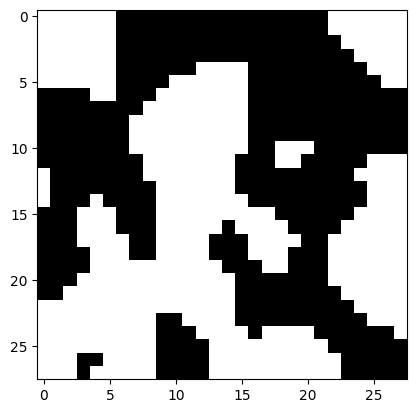

In [19]:


# The method for generating masks for negative data mentioned by Geoffrey Hinton in the article
def mask_gen():
    random_iter = np.random.randint(5,10)
    random_image = np.random.randint(2, size=image_shape).squeeze().astype(np.float32)
    blur_filter = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16
    for i in range(random_iter):
        random_image = convolve2d(random_image, blur_filter, mode='same', boundary='symm')
    mask = (random_image > 0.5).astype(np.float32)
    return mask

# The method for creating masks for negative data that I tried for testing purposes.
def mask_gen1():
    n = image_1d_shape
    arr1 = np.random.normal(loc=0, scale=0.01, size=int(5*n/8))
    arr1 = arr1+ abs(0-arr1.min())
    arr2 = np.random.normal(loc=1, scale=0.01, size=int(3*n/8))
    arr2 = arr2 + abs(1-arr2.max())
    arr = np.concatenate([arr1,arr2])
    np.random.shuffle(arr)
    mask = arr.reshape(image_shape).astype(np.float32)
    return mask

show_image(mask_gen())

### Obtaining the hybrid image by applying the mask

In [20]:
def negative_data_gen(batch):
    batch = batch[0]
    indexes = torch.randperm(batch.shape[0])
    x1 = batch
    x2 = batch[indexes]
    mask = mask_gen()

    # print( "mask size = ", mask.size)
    # print( "x1 size = ", x1.size)
    # print( "x2 size = ", x2.size)

    merged_x1 = x1*mask
    merged_x2 = x2*(1-mask)
    hybrid_image = merged_x1+merged_x2
    return hybrid_image

# Defining the FF Layer

In [21]:
class FFLayer(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, device=None, dtype=None, dropout_rate=0.5):
        super().__init__(in_features, out_features, bias, device, dtype)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.optimizer = Adam(self.parameters(), lr=learning_rate)
        self.threshold = threshold
        self.epoch_num = epochs

    # def forward(self, x):

    #     # print(f"Shape of x::::::::::::::: {x.shape}")


    #     if x.dim() == 1:  # If the tensor is 1D
    #         # print("print working")
    #         x_direction = x / (x.norm(2) + 1e-4)
    #     else:  # For tensors with more dimensions
    #         x_direction = x / (x.norm(2, dim=-1, keepdim=True) + 1e-4)


    #     # print(f"Shape of x_direction : {x_direction.shape}")

    #     x = super().forward(x_direction)
    #     x = self.relu(x)
    #     x = self.dropout(x)
    #     return x
    
    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(torch.mm(x_direction, self.weight.T) + self.bias.unsqueeze(0))







# Defining the FF Network

In [22]:
class FFNet(nn.Module):
    def __init__(self, layers,  device, input_dim):
        super().__init__()
        self.layers = nn.ModuleList()

        # for i in range(len(layers)-1):
        #     if i==0:
        #         self.layers.append(FFLayer( input_dim, layers[i+1]).to(device))
        #     else:
        #         self.layers.append(FFLayer(layers[i], layers[i+1]).to(device))
        for i in range(len(layers)-1):
            self.layers.append(FFLayer(layers[i],layers[i+1]).cuda())
        

    def predict(self,x, softmax_layers, device):
        layers_output = torch.Tensor([]).to(device)
        h = x

        for i, layer in enumerate(self.layers):
            h = layer(h)
            if i in softmax_layers:
                layers_output = torch.cat([layers_output,h],1)

        return layers_output



In [23]:
def count_nonzero_parameterss(model):
      nonzero_params = 0
      for param in model.parameters():
          nonzero_params += torch.count_nonzero(param).item()
      return nonzero_params

def count_nonzero_parameters(model):

    for name, param in model.named_parameters():
        # Count non-zero elements in the parameter tensor
        nonzero_count = torch.count_nonzero(param).item()
        print(f'{name}: {nonzero_count}')

# Training the FF Network
### Training the network in order to learn the representation

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [25]:
device

'cuda'

In [26]:
model = FFNet(layers, device, input_dim =784 )

In [27]:
import copy

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            print( "stopping else")
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False
    

In [28]:
import torch.nn.utils.prune as prune

In [29]:
# def train(model_train_loop, model_test_loop, model, epoch_num, device, es, image_1d_shape, threshold=2):
#     validation_losses = []
#     training_losses = []

#     for epoch in range(epoch_num):
        
        
#        # Reset data iterators at the start of each epoch
#         model_train_loop = iter(train_loader)
#         model_test_loop = iter(test_loader)
        
#         model.train()
#         steps = list(enumerate(model_train_loop))
#         pbar = tqdm(steps, desc=f"Epoch {epoch+1}/{epoch_num}", ncols=100, leave=False)  # Adjust ncols to fit your environment

#         epoch_loss = 0.0

#         for batch_idx, batch in pbar:
#             x_pos = batch[0]
#             x_neg = negative_data_gen(batch)
#             x_pos, x_neg = x_pos.view(-1, image_1d_shape).to(device), x_neg.view(-1, image_1d_shape).to(device)

#             out_pos, out_neg = x_pos, x_neg

#             for i, layer in enumerate(model.layers):
#                 oout_pos = layer.forward(out_pos).pow(2).mean(1)
#                 oout_neg = layer.forward(out_neg).pow(2).mean(1)

#                 loss = torch.log(1 + torch.exp(torch.cat([threshold - oout_pos, oout_neg - threshold]))).mean()

#                 layer.optimizer.zero_grad()
#                 loss.backward()
#                 layer.optimizer.step()

#                 epoch_loss += loss.item()

#                 # Update progress bar description with epoch and loss information
#                 pbar.set_description(f"Epoch: {epoch+1}, Layer: {i+1}/{len(model.layers)}, Loss: {loss.item():.4f}")

#                 out_pos, out_neg = layer.forward(out_pos).detach(), layer.forward(out_neg).detach()

#         # Average training loss for the epoch
#         avg_train_loss = epoch_loss / len(model_train_loop)
#         training_losses.append(avg_train_loss)
#         print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.4f}")

#         # Evaluation and Early Stopping
#         model.eval()
#         with torch.no_grad():

#             # validation loop statrt her
#             vloss_pos = 0

#             # Validation Loop with Progress Bar
#             steps_val = list(enumerate(model_test_loop))
#             pbar_val = tqdm(steps_val, desc=f"Epoch {epoch+1}/{epoch_num} (Validation)", ncols=100)

#             for batch_idx, batch in pbar_val:
#                 x_pos = batch[0]
#                 x_neg = negative_data_gen(batch)
#                 x_pos, x_neg = x_pos.view(-1, image_1d_shape).to(device), x_neg.view(-1, image_1d_shape).to(device)

#                 out_pos, out_neg = x_pos, x_neg

#                 for i, layer in enumerate(model.layers):
#                     oout_pos = layer.forward(out_pos).pow(2).mean(1)
#                     oout_neg = layer.forward(out_neg).pow(2).mean(1)

#                     loss = torch.log(1 + torch.exp(torch.cat([threshold - oout_pos, oout_neg - threshold]))).mean()

#                     vloss_pos += loss.item()

#                     out_pos, out_neg = layer.forward(out_pos).detach(), layer.forward(out_neg).detach()

#             avg_val_loss = vloss_pos / len(model_test_loop)
#             validation_losses.append(avg_val_loss)
#             # if es(model, vloss_pos):
#             #     break  # Stop training if early stopping condition is met

#             # Update progress bar description with validation loss
#             pbar_val.set_description(f"Epoch: {epoch+1}, Validation Loss: {vloss_pos:.4f}, EStop Status: [{es.status}]")

#     return training_losses, validation_losses




In [30]:
vloss_pos = 24.432

In [31]:
print(f", Validation Loss: {vloss_pos:.4}")


, Validation Loss: 24.43


In [32]:
print(model.state_dict())

OrderedDict([('layers.0.weight', tensor([[ 1.2391e-02,  3.3264e-02,  3.4055e-02,  ..., -1.6146e-02,
         -2.0230e-02,  2.5308e-02],
        [ 3.4335e-02,  1.9257e-03,  3.2948e-02,  ...,  4.6050e-04,
          1.6258e-02, -2.8880e-02],
        [-1.0657e-02,  1.5444e-02,  2.7789e-02,  ...,  2.9921e-02,
          2.3921e-02,  2.5706e-02],
        ...,
        [ 3.3493e-02,  2.3086e-02,  1.1204e-03,  ...,  6.9976e-05,
         -2.5103e-02,  5.4729e-03],
        [-2.2741e-02,  1.0522e-02, -2.4170e-02,  ..., -1.8754e-02,
          9.6068e-03,  2.5773e-02],
        [ 2.8686e-03, -2.5031e-02,  2.0268e-02,  ..., -2.4985e-03,
          2.5898e-02,  3.3041e-02]], device='cuda:0')), ('layers.0.bias', tensor([-0.0268, -0.0104,  0.0354,  ..., -0.0268, -0.0351, -0.0073],
       device='cuda:0')), ('layers.1.weight', tensor([[-0.0186,  0.0047,  0.0045,  ..., -0.0163,  0.0138, -0.0123],
        [-0.0214, -0.0008, -0.0141,  ...,  0.0112,  0.0103,  0.0215],
        [ 0.0043, -0.0048,  0.0130,  ...,  

In [33]:
count_nonzero_parameters(model)

layers.0.weight: 1568000
layers.0.bias: 2000
layers.1.weight: 3999999
layers.1.bias: 2000
layers.2.weight: 3999999
layers.2.bias: 2000
layers.3.weight: 4000000
layers.3.bias: 2000


In [34]:
count_nonzero_parameterss(model)

13575998

In [38]:
print(model.state_dict())

OrderedDict([('layers.0.weight', tensor([[ 1.2391e-02,  3.3264e-02,  3.4055e-02,  ..., -1.6146e-02,
         -2.0230e-02,  2.5308e-02],
        [ 3.4335e-02,  1.9257e-03,  3.2948e-02,  ...,  4.6050e-04,
          1.6258e-02, -2.8880e-02],
        [-1.0657e-02,  1.5444e-02,  2.7789e-02,  ...,  2.9921e-02,
          2.3921e-02,  2.5706e-02],
        ...,
        [ 3.3493e-02,  2.3086e-02,  1.1204e-03,  ...,  6.9976e-05,
         -2.5103e-02,  5.4729e-03],
        [-2.2741e-02,  1.0522e-02, -2.4170e-02,  ..., -1.8754e-02,
          9.6068e-03,  2.5773e-02],
        [ 2.8686e-03, -2.5031e-02,  2.0268e-02,  ..., -2.4985e-03,
          2.5898e-02,  3.3041e-02]], device='cuda:0')), ('layers.0.bias', tensor([-0.0268, -0.0104,  0.0354,  ..., -0.0268, -0.0351, -0.0073],
       device='cuda:0')), ('layers.1.weight', tensor([[-0.0186,  0.0047,  0.0045,  ..., -0.0163,  0.0138, -0.0123],
        [-0.0214, -0.0008, -0.0141,  ...,  0.0112,  0.0103,  0.0215],
        [ 0.0043, -0.0048,  0.0130,  ...,  

In [37]:
import torch.nn.utils.prune as prune

In [20]:
# def train(model_train_loop, model_test_loop, model, epoch_num, device, es, image_1d_shape, threshold=2):
#     validation_losses = []
#     training_losses = []

#     for epoch in range(epoch_num):
        
#         # Reset data iterators at the start of each epoch
#         model_train_loop = iter(train_loader)
#         model_test_loop = iter(test_loader)
        
#         model.train()
#         pbar = tqdm(enumerate(model_train_loop), desc=f"Epoch {epoch+1}/{epoch_num}", ncols=100, leave=False)  # Adjust ncols to fit your environment

#         epoch_loss = 0.0

#         for batch_idx, batch in pbar:
#             x_pos = batch[0]
#             x_neg = negative_data_gen(batch)
#             x_pos, x_neg = x_pos.view(-1, image_1d_shape).to(device), x_neg.view(-1, image_1d_shape).to(device)

#             out_pos, out_neg = x_pos, x_neg

#             for i, layer in enumerate(model.layers):
#                 oout_pos = layer.forward(out_pos).pow(2).mean(1)
#                 oout_neg = layer.forward(out_neg).pow(2).mean(1)

#                 loss = torch.log(1 + torch.exp(torch.cat([threshold - oout_pos, oout_neg - threshold]))).mean()

#                 layer.optimizer.zero_grad()
#                 loss.backward()  # No need to retain graph
#                 layer.optimizer.step()

#                 epoch_loss += loss.item()

#                 # Update progress bar description with epoch and loss information
#                 pbar.set_description(f"Epoch: {epoch+1}, Layer: {i+1}/{len(model.layers)}, Loss: {loss.item():.4f}")

#                 out_pos, out_neg = layer.forward(out_pos).detach(), layer.forward(out_neg).detach()
    

#         # Average training loss for the epoch
#         avg_train_loss = epoch_loss / len(model_train_loop)
#         training_losses.append(avg_train_loss)
#         print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.4f}")

#         # Evaluation and Early Stopping
#         # model.eval()
#         with torch.no_grad():
#             vloss_pos = 0

#             # Validation Loop with Progress Bar
#             pbar_val = tqdm(enumerate(model_test_loop), desc=f"Epoch {epoch+1}/{epoch_num} (Validation)", ncols=100)

#             for batch_idx, batch in pbar_val:
#                 x_pos = batch[0]
#                 x_neg = negative_data_gen(batch)
#                 x_pos, x_neg = x_pos.view(-1, image_1d_shape).to(device), x_neg.view(-1, image_1d_shape).to(device)

#                 out_pos, out_neg = x_pos, x_neg

#                 for i, layer in enumerate(model.layers):
#                     oout_pos = layer.forward(out_pos).pow(2).mean(1)
#                     oout_neg = layer.forward(out_neg).pow(2).mean(1)
                     
#                     loss = torch.log(1 + torch.exp(torch.cat([threshold - oout_pos, oout_neg - threshold]))).mean()

#                     vloss_pos += loss.item()

#                     out_pos, out_neg = layer.forward(out_pos).detach(), layer.forward(out_neg).detach()
           
#             avg_val_loss = vloss_pos / len(model_test_loop)
#             validation_losses.append(avg_val_loss)
#             # Update progress bar description with validation loss
#             pbar_val.set_description(f"Epoch: {epoch+1}, Validation Loss: {vloss_pos:.4f}, EStop Status: [{es.status}]")

#     return training_losses, validation_losses
    

# # l = 5
# # es = EarlyStopping()
# # pertopune = 0.04

# # for i in range(l):
    
# #     # Reset train and test data loaders
# #     model_train_loop = tqdm_notebook(iter(train_loader), leave=False)
# #     model_test_loop = tqdm_notebook(iter(test_loader), leave=False)
    
#     # Start training
# #     training_losses, validation_losses = train(model_train_loop, model_test_loop, model, epochs, device, es, image_1d_shape)

# #     # Plot training and validation loss vs epoch
# #     plt.figure(figsize=(12, 6))
# #     plt.subplot(1, 2, 1)
# #     plt.plot(training_losses, marker='o', linestyle='-', color='b')
# #     plt.title('Training Loss vs Epoch')
# #     plt.xlabel('Epoch')
# #     plt.ylabel('Training Loss')
# #     plt.grid(True)

# #     plt.subplot(1, 2, 2)
# #     plt.plot(validation_losses, marker='o', linestyle='-', color='r')
# #     plt.title('Validation Loss vs Epoch')
# #     plt.xlabel('Epoch')
# #     plt.ylabel('Validation Loss')
# #     plt.grid(True)
    
# #     plt.tight_layout()
# #     plt.savefig(f'training_validation_loss_plot_{i}.png', dpi=300, bbox_inches='tight')
# #     plt.show()

# #     print("Iteration:", i)

# #     parameters_to_prune = []

# #     for layer in model.layers:
# #         if isinstance(layer, nn.Linear):
# #             parameters_to_prune.append((layer, 'weight'))

# #     prune.global_unstructured(
# #         parameters_to_prune,
# #         pruning_method=prune.L1Unstructured,
# #         amount=pertopune * (i + 1) 
# #     )

# # for layer in model.layers:
# #     if isinstance(layer, nn.Linear):
# #         prune.remove(layer, 'weight')


# testing 


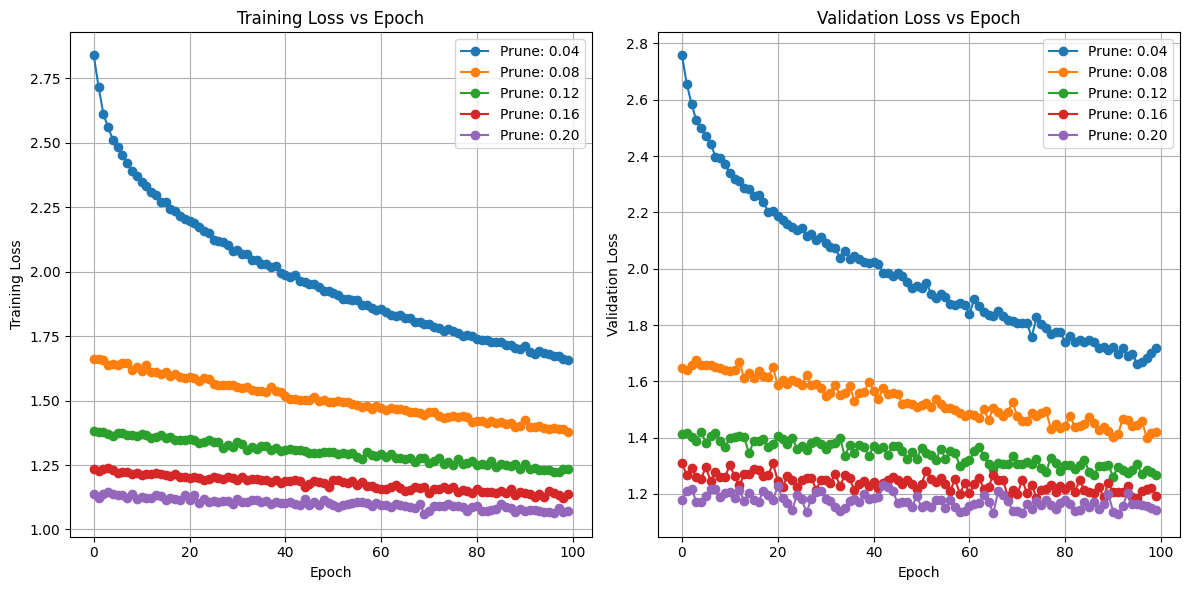

In [39]:
def train(train_loader, test_loader, model, epoch_num, device, es, image_1d_shape, threshold=2):
    validation_losses = []
    training_losses = []

    for epoch in range(epoch_num):
        model.train()
        epoch_loss = 0.0
        # print(f"Epoch {epoch+1}/{epoch_num} (Training)")
        # for batch in tqdm(train_loader):
            # print('hello')
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epoch_num} (Training)", leave=False)
        for batch in pbar:
            x_pos = batch[0]
            # print('before')
            x_neg = negative_data_gen(batch)
            # print('after')
            x_pos, x_neg = x_pos.view(-1, image_1d_shape).to(device), x_neg.view(-1, image_1d_shape).to(device)

            out_pos, out_neg = x_pos, x_neg

            for i, layer in enumerate(model.layers):
                oout_pos = layer.forward(out_pos).pow(2).mean(1)
                oout_neg = layer.forward(out_neg).pow(2).mean(1)

                loss = torch.log(1 + torch.exp(torch.cat([threshold - oout_pos, oout_neg - threshold]))).mean()

                layer.optimizer.zero_grad()
                loss.backward()
                layer.optimizer.step()

                epoch_loss += loss.item()

                pbar.set_description(f"Epoch: {epoch+1}, Layer: {i+1}/{len(model.layers)}, Loss: {loss.item():.4f}")

                out_pos, out_neg = layer.forward(out_pos).detach(), layer.forward(out_neg).detach()

        avg_train_loss = epoch_loss / len(train_loader)
        # print(f"avg training loss: {avg_train_loss}")
        training_losses.append(avg_train_loss)

        model.eval()
        vloss_pos = 0

        pbar_val = tqdm(test_loader, desc=f"Epoch {epoch+1}/{epoch_num} (Validation)", leave=False)
        with torch.no_grad():
            for batch in pbar_val:
            # print(f"epoch {epoch+1}/{epoch_num} (Validation)")
            # for batch in tqdm(test_loader):
                x_pos = batch[0]
                x_neg = negative_data_gen(batch)
                x_pos, x_neg = x_pos.view(-1, image_1d_shape).to(device), x_neg.view(-1, image_1d_shape).to(device)

                out_pos, out_neg = x_pos, x_neg

                for i, layer in enumerate(model.layers):
                    oout_pos = layer.forward(out_pos).pow(2).mean(1)
                    oout_neg = layer.forward(out_neg).pow(2).mean(1)

                    loss = torch.log(1 + torch.exp(torch.cat([threshold - oout_pos, oout_neg - threshold]))).mean()

                    vloss_pos += loss.item()

                    out_pos, out_neg = layer.forward(out_pos).detach(), layer.forward(out_neg).detach()

            avg_val_loss = vloss_pos / len(test_loader)
            validation_losses.append(avg_val_loss)
            pbar_val.set_description(f"Epoch: {epoch+1}, Validation Loss: {vloss_pos:.4f}, EStop Status: [{es.status}]")
            # print(f"avg validation loss: {avg_val_loss}")

    return training_losses, validation_losses

l = 5
es = EarlyStopping()
pertopune = 0.04

all_training_losses = []
all_validation_losses = []

for i in range(l):
    # Start training
    
    training_losses, validation_losses = train(train_loader, test_loader, model, epochs, device, es, image_1d_shape)
    
    # Append losses for plotting later
    all_training_losses.append((training_losses, pertopune*(i+1)))
    all_validation_losses.append((validation_losses, pertopune*(i+1)))

    parameters_to_prune = []
    
    for layer in model.layers:
        if isinstance(layer, nn.Linear):
            parameters_to_prune.append((layer, 'weight'))
     
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=pertopune*(i+1)
    )
    
    for layer in model.layers:
        if isinstance(layer, nn.Linear):
            prune.remove(layer, 'weight')
    
# Plot all training and validation losses in a single graph
plt.figure(figsize=(12, 6))

# Plot training loss curves
plt.subplot(1, 2, 1)
for idx, (losses, prune_val) in enumerate(all_training_losses):
    plt.plot(losses, marker='o', linestyle='-', label=f'Prune: {prune_val:.2f}')
plt.title('Training Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)

# Plot validation loss curves
plt.subplot(1, 2, 2)
for idx, (losses, prune_val) in enumerate(all_validation_losses):
    plt.plot(losses, marker='o', linestyle='-', label=f'Prune: {prune_val:.2f}')
plt.title('Validation Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
 
plt.tight_layout()
 
# Save the figure with all plots
plt.savefig('training_validation_loss_all_plots.png', dpi=300, bbox_inches='tight')

# Show the plot (optional, remove if you don't want to display it)
plt.show() 
            

In [40]:
torch.save( model.state_dict(), 'unsupervised_ff_model.pth')


In [27]:
all_validation_losses

[([424.8419173359871,
   419.3568702340126,
   416.83201533555984,
   413.6595047712326,
   409.78352266550064],
  0.04),
 ([403.8566859960556,
   401.1523411870003,
   398.8057594895363,
   396.51411616802216,
   394.13215059041977],
  0.08),
 ([391.6459275484085,
   389.2640134692192,
   387.8347603082657,
   385.70855259895325,
   385.15670442581177],
  0.12),
 ([384.8737441599369,
   383.1385500729084,
   383.2841335237026,
   381.53789269924164,
   382.91044449806213],
  0.16),
 ([380.6529126763344,
   377.3794792294502,
   378.6143035888672,
   378.73889514803886,
   380.24845707416534],
  0.2)]

# testing 2

In [39]:
from torch.optim import Adam

import torch.nn.utils.prune as prune
import torch.autograd.profiler as profiler


class FFLayer(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, device='cpu', dtype=None, dropout_rate=0.5):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.optimizer = Adam(self.parameters(), lr=0.001)  # Assuming a learning rate
        self.threshold = 2  # Assuming a threshold value

    def forward(self, x):
        if x.dim() == 1:
            x_direction = x / (x.norm(2) + 1e-4)
        else:
            x_direction = x / (x.norm(2, dim=-1, keepdim=True) + 1e-4)

        x = super().forward(x_direction)
        x = self.relu(x)
        x = self.dropout(x)
        return x

class FFNet(nn.Module):
    def __init__(self, layers, device, input_dim):
        super().__init__()
        self.layers = nn.ModuleList([FFLayer(input_dim if i == 0 else layers[i], layers[i+1]).to(device)
                                     for i in range(len(layers)-1)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def predict(self, x, softmax_layers, device):
        layers_output = torch.Tensor([]).to(device)
        h = x
        for i, layer in enumerate(self.layers):
            h = layer(h)
            if i in softmax_layers:
                layers_output = torch.cat([layers_output, h], 1)
        return layers_output


# Profiling Training Function
def profiled_train(train_loader, test_loader, model, epoch_num, device, es, image_1d_shape, threshold=2):
    validation_losses = []
    training_losses = []

    for epoch in range(epoch_num):
        model.train()
        epoch_loss = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epoch_num} (Training)", leave=False)
        for batch in pbar:
            x_pos = batch[0].view(-1, image_1d_shape).to(device)
            x_neg = negative_data_gen(batch).view(-1, image_1d_shape).to(device)

            out_pos, out_neg = x_pos, x_neg

            for i, layer in enumerate(model.layers):
                oout_pos = layer.forward(out_pos).pow(2).mean(1)
                oout_neg = layer.forward(out_neg).pow(2).mean(1)

                loss = torch.log(1 + torch.exp(torch.cat([threshold - oout_pos, oout_neg - threshold]))).mean()

                layer.optimizer.zero_grad()
                loss.backward()
                layer.optimizer.step()

                epoch_loss += loss.item()

                pbar.set_description(f"Epoch: {epoch+1}, Layer: {i+1}/{len(model.layers)}, Loss: {loss.item():.4f}")

                out_pos, out_neg = layer.forward(out_pos).detach(), layer.forward(out_neg).detach()

        training_losses.append(epoch_loss / len(train_loader))

        # Validation
        model.eval()
        vloss_pos = 0
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f"Epoch {epoch+1}/{epoch_num} (Validation)", leave=False):
                x_pos = batch[0].view(-1, image_1d_shape).to(device)
                x_neg = negative_data_gen(batch).view(-1, image_1d_shape).to(device)

                out_pos, out_neg = x_pos, x_neg
                for layer in model.layers:
                    oout_pos = layer.forward(out_pos).pow(2).mean(1)
                    oout_neg = layer.forward(out_neg).pow(2).mean(1)

                    loss = torch.log(1 + torch.exp(torch.cat([threshold - oout_pos, oout_neg - threshold]))).mean()

                    vloss_pos += loss.item()

                validation_losses.append(vloss_pos / len(test_loader))

    return training_losses, validation_losses

# Function to be profiled
def run_profiled_training(train_loader, test_loader, model, epochs, device, es, image_1d_shape):
    with profiler.profile( record_shapes=True, use_device = 'cuda') as prof:
        training_losses, validation_losses = profiled_train(train_loader, test_loader, model, epochs, device, es, image_1d_shape)
    print(prof.key_averages().table(sort_by="cuda_time_total"))
    return training_losses, validation_losses

# Assume you've already defined train_loader, test_loader, model, epochs, image_1d_shape, etc.

l = 5
es = EarlyStopping()
pertopune = 0.04

all_training_losses = []
all_validation_losses = []

for i in range(l):
    # Start profiling and training
    training_losses, validation_losses = run_profiled_training(train_loader, test_loader, model, epochs, device, es, image_1d_shape)

    # Append losses for plotting later
    all_training_losses.append((training_losses, pertopune*(i+1)))
    all_validation_losses.append((validation_losses, pertopune*(i+1)))

    parameters_to_prune = []
    for layer in model.layers:
        if isinstance(layer, nn.Linear):
            parameters_to_prune.append((layer, 'weight'))

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=pertopune*(i+1)
    )

    for layer in model.layers:
        if isinstance(layer, nn.Linear):
            prune.remove(layer, 'weight')

# Plot all training and validation losses in a single graph
plt.figure(figsize=(12, 6))

# Plot training loss curves
plt.subplot(1, 2, 1)
for idx, (losses, prune_val) in enumerate(all_training_losses):
    plt.plot(losses, marker='o', linestyle='-', label=f'Prune: {prune_val:.2f}')
plt.title('Training Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)

# Plot validation loss curves
plt.subplot(1, 2, 2)
for idx, (losses, prune_val) in enumerate(all_validation_losses):
    plt.plot(losses, marker='o', linestyle='-', label=f'Prune: {prune_val:.2f}')
plt.title('Validation Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()

# Save the figure with all plots
plt.savefig('training_validation_loss_all_plots.png', dpi=300, bbox_inches='tight')

# Show the plot (optional, remove if you don't want to display it)
plt.show()


Epoch: 1, Layer: 2/4, Loss: 0.6890:  94%|█████████▍| 885/938 [07:06<34:35, 39.15s/it]

In [ ]:
torch.save( model.state_dict(), 'unsupervised_ff_model2.pth')


In [106]:
count_nonzero_parameters(model) 
print("\n")
print( "total number of non-zero parameters : ", count_nonzero_parameterss(model) )


layers.0.bias: 2000
layers.0.weight: 1222569
layers.1.bias: 2000
layers.1.weight: 3255172
layers.2.bias: 2000
layers.2.weight: 2720734
layers.3.bias: 2000
layers.3.weight: 2299125


total number of non-zero parameters :  9505600


In [67]:
count_nonzero_parameterss(model) 

9505600

In [107]:
print(model.state_dict())  

OrderedDict([('layers.0.bias', tensor([-0.1075, -0.1158, -0.2135,  ...,  0.0405,  0.3740,  0.6517],
       device='cuda:0')), ('layers.0.weight', tensor([[-0., -0., -0.,  ..., -0., 0., -0.],
        [-0., -0., 0.,  ..., 0., 0., 0.],
        [-0., -0., -0.,  ..., 0., -0., 0.],
        ...,
        [-0., 0., -0.,  ..., -0., -0., 0.],
        [0., -0., 0.,  ..., -0., 0., -0.],
        [0., 0., 0.,  ..., -0., 0., 0.]], device='cuda:0')), ('layers.1.bias', tensor([0.1944, 0.2392, 0.3935,  ..., 0.2390, 0.3855, 0.4267], device='cuda:0')), ('layers.1.weight', tensor([[-0.1239, -0.1229, -0.1362,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1129,  0.0736,  0.1367,  ...,  0.0550, -0.0000,  0.0413],
        [ 0.0666,  0.0000,  0.1213,  ...,  0.0764,  0.1277, -0.0000],
        ...,
        [-0.0867, -0.1874, -0.0000,  ...,  0.1264, -0.2082,  0.0000],
        [-0.3336, -0.5603, -0.4058,  ..., -0.3772,  0.6969,  0.7403],
        [-0.0000, -0.0800, -0.1138,  ...,  0.1313,  0.2314,  0.1796]],
       d

In [68]:
torch.save(model.state_dict(), 'model_mlp.pth')

In [70]:

modell = FFNet(layers, device, input_dim =784 )
modell.load_state_dict(torch.load('model_mlp.pth'))

<All keys matched successfully>

# Defining the Linear Classifier

In [85]:
class LinearClassification(nn.Module):
    
    def __init__(self, input_dimension):
        super().__init__()
        self.epoch_losses = []
        self.linear = torch.nn.Linear(input_dimension, 10).to(device)
        self.optimizer = SGD(self.parameters(), lr=learning_rate_lc)
        self.criterion = nn.CrossEntropyLoss()
        self.softmax = nn.Softmax()

    def forward(self,x):
        return self.linear(x)

    def accuracy_f(self, y_pred, y_true):
        batch_size = y_pred.size(0)
        _, predicted_labels = y_pred.max(1)
        y_pred_onehot = torch.zeros_like(y_pred)
        y_pred_onehot.scatter_(1, predicted_labels.view(-1,1), 1)
        correct = (y_pred_onehot == y_true).sum().item()
        accuracy = correct / (batch_size * y_true.size(1))
        return accuracy

    def predict(self,x):
        x = x.view(-1,image_1d_shape).to(device)
        h_activity = model.predict(x,softmax_layers)
        y_h = self.forward(h_activity)
        soft_out = self.softmax(y_h)
        return soft_out.argmax()


    def train(self, data_loader, epoch_num, device="cpu"):
        linear_loop = tqdm_notebook(range(epoch_num),total=epoch_num)
        for i in linear_loop:
            batch_losses = []
            for batch in iter(data_loader):
                x,y = batch
                x = x.view(-1,image_1d_shape).to(device)
                y_r = label_to_oh(y).to(device)
                h_activity = model.predict(x,softmax_layers, device)
                y_h = self.forward(h_activity)
                loss = self.criterion(y_h,y_r)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                batch_losses.append(loss)
            self.epoch_losses.append(float(sum(batch_losses)/len(batch_losses)))
            linear_loop.set_description(f"Epoch [{i+1}/{epoch_num}]: ")
            linear_loop.set_postfix(loss=self.epoch_losses[i])

    def test(self, data_loader, device="cpu"):
        batch_losses = []
        test_loss = 0
        batch_accuracy = []
        for batch in iter(data_loader):
            x,y = batch
            x = x.view(-1,image_1d_shape).to(device)
            y_r = label_to_oh(y).to(device)
            h_activity = model.predict(x,softmax_layers, device)
            y_h = self.forward(h_activity)
            accuracy = self.accuracy_f(y_h,y_r)
            loss = self.criterion(y_h,y_r)
            batch_losses.append(loss)
            batch_accuracy.append(float(accuracy))
        test_loss = float(sum(batch_losses)/len(batch_losses))
        test_accuracy = float(sum(batch_accuracy)/len(batch_accuracy))
        return test_loss,test_accuracy



In [72]:
def neuron_num(layers,softmax_layers):
    num = 0
    layers = layers[1:]
    for i in softmax_layers:
            num += layers[i]
    return num

# Training the Linear Classifier

---


### Training the linear classifier in order to learn a simple linear transformation for predicting the labels

In [86]:
linear_model = LinearClassification( neuron_num(layers,softmax_layers) )
losses = linear_model.train( train_loader, epochs, device )

  0%|          | 0/10 [00:00<?, ?it/s]

In [87]:
torch.save(linear_model.state_dict(), 'model_linear.pth')

In [88]:
linear_model = LinearClassification(neuron_num(layers,softmax_layers))
linear_model.load_state_dict(torch.load('model_linear.pth'))

<All keys matched successfully>

In [89]:
loss, accuracy = (linear_model.test(test_loader, device))

TypeError: FFNet.predict() missing 1 required positional argument: 'device'

In [ ]:
loss

NameError: name 'loss' is not defined

In [ ]:
accuracy

0.9886750637755102

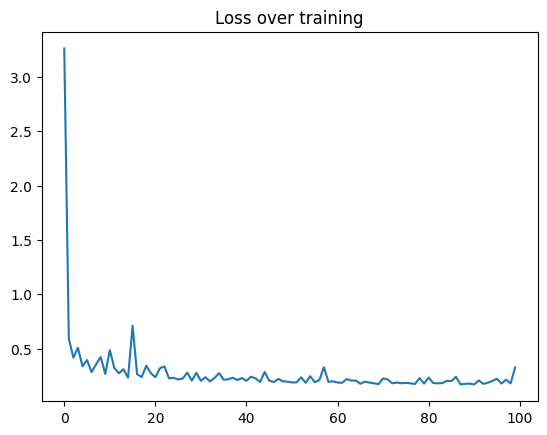

In [ ]:
plt.plot(linear_model.epoch_losses)
plt.title("Loss over training")
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


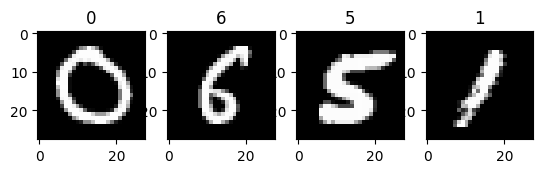

In [ ]:
batch = next(iter(test_loader))
n = 4
fig, ax1 = plt.subplots(1, n)
for i in range(n):
    x = batch[0][i]
    num=int(linear_model.predict(x))
    ax1[i].imshow(x.squeeze(),cmap="gray")
    ax1[i].set_title(str(num))
plt.show()